In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img
import os
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
# !nvidia-smi

In [4]:

def load_dataset(directory):
    images, labels = [], []
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    for category in categories:
        path_to_category = os.path.join(directory, category)
        if os.path.isdir(path_to_category):
            for file in os.listdir(path_to_category):
                full_path = os.path.join(path_to_category, file)
                if os.path.isfile(full_path):
                    with Image.open(full_path) as img:
                        img = img.resize((128, 128)).convert('RGB')
                        images.append(np.array(img))
                        labels.append(category)
    return images, labels

def convert_labels_to_one_hot(labels):
    if not labels:
        raise ValueError("No labels found. Ensure the dataset is loaded correctly.")
    label_encoder = OneHotEncoder(sparse_output=False)
    labels_as_array = np.array(labels).reshape(-1, 1)
    one_hot_labels = label_encoder.fit_transform(labels_as_array)
    return one_hot_labels


In [5]:
# Load training data
training_folder = 'archive/Training'
train_images, train_labels = load_dataset(training_folder)
train_labels_one_hot = convert_labels_to_one_hot(train_labels) #convert the test label to one hot encoded vector


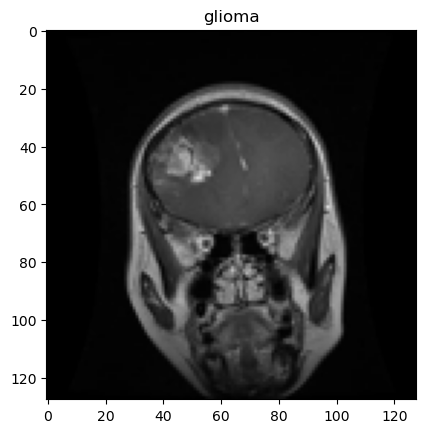

In [6]:
plt.imshow(train_images[0])
plt.title(train_labels[0])
plt.show()

In [7]:
# Load testing data
testing_folder = 'archive/Testing'
test_images, test_labels = load_dataset(testing_folder)
test_labels_one_hot = convert_labels_to_one_hot(test_labels) #convert the test label to one hot encoded vector


In [8]:
# Converting images to numpy arrays and normalize
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0


In [9]:

print(f"Training data shape: {train_images.shape}, Training labels shape: {train_labels_one_hot.shape}")
print(f"Testing data shape: {test_images.shape}, Testing labels shape: {test_labels_one_hot.shape}")



Training data shape: (5712, 128, 128, 3), Training labels shape: (5712, 4)
Testing data shape: (1311, 128, 128, 3), Testing labels shape: (1311, 4)


In [10]:
# Shuffle training data and labels
shuffle_index = np.random.permutation(len(train_images))
train_images = train_images[shuffle_index]
train_labels_one_hot = train_labels_one_hot[shuffle_index]


In [11]:
# Define class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

### Plotting some of the images

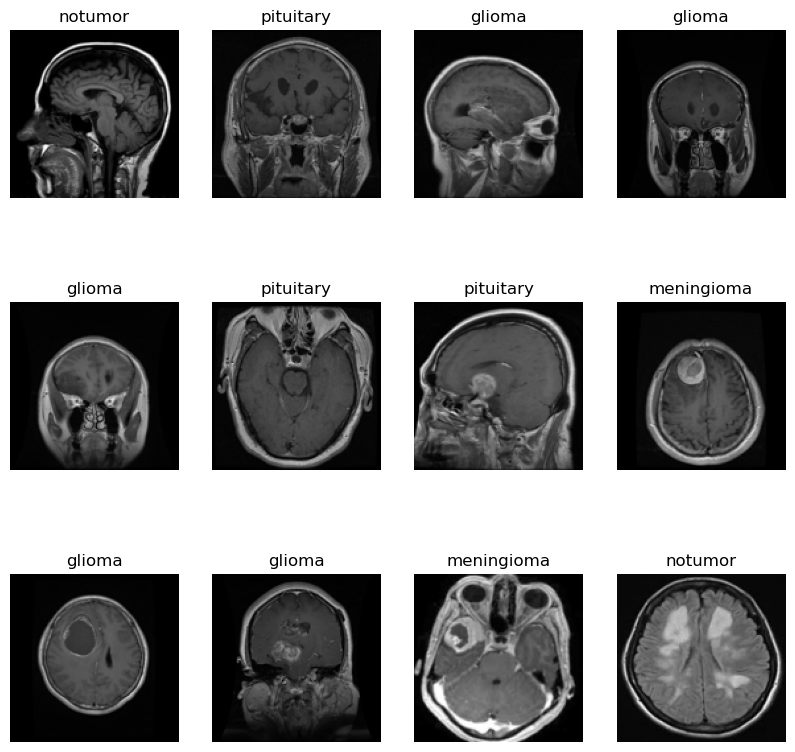

In [10]:
plt.figure(figsize=(10, 10))
indices = np.random.choice(len(train_images), 12, replace=False)

for i, idx in enumerate(indices):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(train_images[idx])
    plt.title(class_labels[np.argmax(train_labels_one_hot[idx])])
    plt.axis('off')

plt.show()

## Data Augmentation

In [11]:

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)


In [15]:
train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=32)

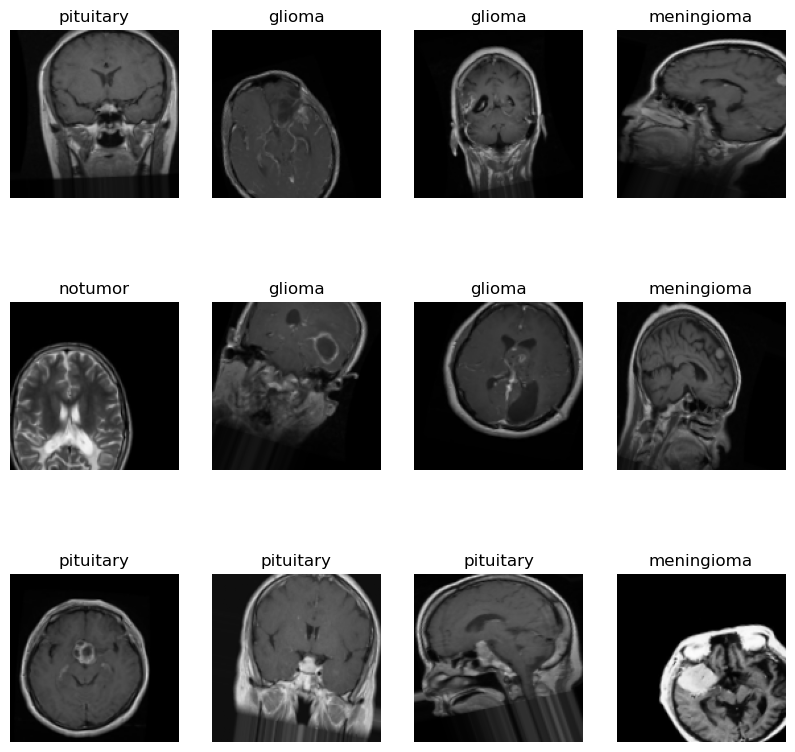

In [16]:
# For demonstration, plot augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    break  # Only take the first batch for plotting

plt.show()

## RESNET

In [14]:
# Define paths for saved models
input_path = 'RESNET/saved-model/'
working_path = 'RESNET/working-model/'

# Custom callback to print when the model is saved
class MyModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if self.save_best_only:
            current_value = logs.get(self.monitor)
            if current_value == self.best:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current_value}, saving model weights to {self.filepath}")
                # Save model weights
                model.save_weights(os.path.join(working_path, 'best_model_weights.weights.h5'))
                
                # Save model architecture
                model_json = model.to_json()
                with open(os.path.join(working_path, 'best_model_architecture.json'), 'w') as json_file:
                    json_file.write(model_json)


In [15]:

# Function to load model if files exist
def load_model_if_exists(model_path, weight_file, arch_file):
    if os.path.exists(weight_file) and os.path.exists(arch_file):
        with open(arch_file, 'r') as json_file:
            loaded_model_json = json_file.read()
        loaded_model = tf.keras.models.model_from_json(loaded_model_json)
        loaded_model.load_weights(weight_file)
        print("Model loaded from saved files.")
        return loaded_model
    return None


def convert_tensor_to_list(value):
    if isinstance(value, tf.Tensor):
        return value.numpy().tolist()
    return value

In [16]:

# Check if saved model exists and load it
model = load_model_if_exists(
    working_path, 
    os.path.join(working_path, 'best_model_weights.weights.h5'), 
    os.path.join(working_path, 'best_model_architecture.json')
)

if model is None:
    model = load_model_if_exists(
        input_path, 
        os.path.join(input_path, 'best_model_weights.weights.h5'), 
        os.path.join(input_path, 'best_model_architecture.json')
    )
    if model:
        with open(os.path.join(input_path, 'history.json'), 'r') as file:
            history = json.load(file)


In [17]:

if model is None:
    print("No saved model found. Training a new model...")

    # Load ResNet50 model without the top layers and with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)  # Change the number of classes to 4

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy',
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.F1Score()])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = MyModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )

    # Train the model and save training history
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        epochs=10,
        batch_size=32,
        validation_data=(test_images, test_labels_one_hot), 
        callbacks=[checkpoint]
    )

    # Save training history
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [convert_tensor_to_list(val) for val in value]

    with open(os.path.join(working_path, 'history.json'), 'w') as file:
        json.dump(history_dict, file)

    # Verify if the model files were saved successfully
    if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
        print("Model saved successfully.")
    else:
        print("Model was not saved.")


No saved model found. Training a new model...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4831 - auc: 0.7337 - f1_score: 0.4639 - loss: 1.1635 - precision: 0.7199 - recall: 0.2049
Epoch 1: val_accuracy improved from -inf to 0.55378, saving model to best_model.keras
Epoch 1: val_accuracy improved to 0.5537757277488708, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 536ms/step - accuracy: 0.4836 - auc: 0.7341 - f1_score: 0.4644 - loss: 1.1628 - precision: 0.7201 - recall: 0.2054 - val_accuracy: 0.5538 - val_auc: 0.8279 - val_f1_score: 0.5333 - val_loss: 0.9712 - val_precision: 0.6718 - val_recall: 0.3669
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6748 - auc: 0.8901 - f1_score: 0.6665 - loss: 0.8122 - precision: 0.7719 - recall: 0.4991
Epoch 2: val_accuracy improved from 0.55378 to 0.59497, saving model to best_model.keras
Epoch 2: val_accuracy improved to 0.5949656963348389, saving model weights to best_model.ke

## GoogleNet Inception V3

In [18]:
# Define paths for saved models
input_path = 'GoogleNet/saved-model/'
working_path = 'GoogleNet/working-model/'


# Check if saved model exists and load it
model = load_model_if_exists(
    working_path, 
    os.path.join(working_path, 'best_model_weights.weights.h5'), 
    os.path.join(working_path, 'best_model_architecture.json')
)

if model is None:
    model = load_model_if_exists(
        input_path, 
        os.path.join(input_path, 'best_model_weights.weights.h5'), 
        os.path.join(input_path, 'best_model_architecture.json')
    )
    if model:
        with open(os.path.join(input_path, 'history.json'), 'r') as file:
            history = json.load(file)


In [19]:

if model is None:
    print("No saved model found. Training a new model...")

    # Load InceptionV3 model without the top layers and with pre-trained weights
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)  # Change the number of classes to 4

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy',
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.F1Score()])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = MyModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )

    # Train the model and save training history
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        epochs=10,
        batch_size=32,
        validation_data=(test_images, test_labels_one_hot), 
        callbacks=[checkpoint]
    )

    # Save training history
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [convert_tensor_to_list(val) for val in value]

    with open(os.path.join(working_path, 'history.json'), 'w') as file:
        json.dump(history_dict, file)

    # Verify if the model files were saved successfully
    if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
        print("Model saved successfully.")
    else:
        print("Model was not saved.")


No saved model found. Training a new model...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6591 - auc_1: 0.8288 - f1_score: 0.6485 - loss: 2.8669 - precision_1: 0.6739 - recall_1: 0.6427
Epoch 1: val_accuracy improved from -inf to 0.85126, saving model to best_model.keras
Epoch 1: val_accuracy improved to 0.8512585759162903, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 312ms/step - accuracy: 0.6598 - auc_1: 0.8293 - f1_score: 0.6492 - loss: 2.8571 - precision_1: 0.6746 - recall_1: 0.6433 - val_accuracy: 0.8513 - val_auc_1: 0.9719 - val_f1_score: 0.8450 - val_loss: 0.3969 - val_precision_1: 0.8704 - val_recall_1: 0.8299
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8765 - auc_1: 0.9804 - f1_score: 0.8721 - loss: 0.3256 - precision_1: 0.8942 - recall_1: 0.8661
Epoch 2: val_accuracy improved from 0.85126 to 0.87338, saving model to best_model.keras
Epoch 2: val_accuracy improved to 0.873379111289978, saving model we

## Custom Model with 5 CNNs and MaxPooling layers

In [21]:
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 4th Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 5th Convolutional Layer
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,852 (4.05 MB)

 Trainable params: 1,062,852 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Define paths for saved models
input_path = 'CustomModel/saved-model/'
working_path = 'CustomModel/working-model/'


model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.F1Score()])

# Define ModelCheckpoint callback to save the best model
checkpoint = MyModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# Train the model and save training history
history = model.fit(
    train_images, 
    train_labels_one_hot, 
    epochs=10,
    batch_size=32,
    validation_data=(test_images, test_labels_one_hot), 
    callbacks=[checkpoint]
)


history_dict = {}
for key, value in history.history.items():
    history_dict[key] = [convert_tensor_to_list(val) for val in value]
    
with open(os.path.join(working_path, 'history.json'), 'w') as file:
    json.dump(history_dict, file)

# Verify if the model files were saved successfully
if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
    print("Model saved successfully.")
else:
    print("Model was not saved.")


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4887 - auc_1: 0.7585 - f1_score: 0.4555 - loss: 1.0859 - precision_1: 0.6677 - recall_1: 0.2715
Epoch 1: val_accuracy improved from -inf to 0.73455, saving model to best_model.keras
Epoch 1: val_accuracy improved to 0.7345537543296814, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 224ms/step - accuracy: 0.4895 - auc_1: 0.7592 - f1_score: 0.4565 - loss: 1.0845 - precision_1: 0.6683 - recall_1: 0.2728 - val_accuracy: 0.7346 - val_auc_1: 0.9311 - val_f1_score: 0.7122 - val_loss: 0.6274 - val_precision_1: 0.7832 - val_recall_1: 0.6888
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8097 - auc_1: 0.9582 - f1_score: 0.7970 - loss: 0.4838 - precision_1: 0.8357 - recall_1: 0.7769
Epoch 2: val_accuracy improved from 0.73455 to 0.78413, saving model to best_model.keras
Epoch 2: val_accuracy improved to 0.7841342687606812, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━